# Notebook to demonstrate:

## Step 0. Inspect HHS data and CovidEstim.org data

## Step 1. Population model being optimized with gradient descent

## Step 2. Population model forecasting hospital-admissions 

## Step 3. Inspect learned parameters with respect to their prior distributions

In [1]:
# import plot tools
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes
import numpy as np

%load_ext autoreload
%autoreload 2

# import the 2 objects needed to create the population model
from PopulationData import PopulationData
from HospitalData import HospitalData

# import the population model
from PopulationModel import PopulationModel


# Step 0. 
## Inspect the ground-truth data of hospital-admissions that we retrieve from the Health Human Services (HHS) website

 - we define that we want to retrieve data from lookback_date until '20210601' via the HospitalData.py object

 - we will train our model to forecast for the past time period of training_start_date to training_end_date (green shaded in plot)

<ipython-input-2-78cc4572e2d0>:26: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(range(len(date_xlabels)), labels=date_xlabels, Rotation=90);


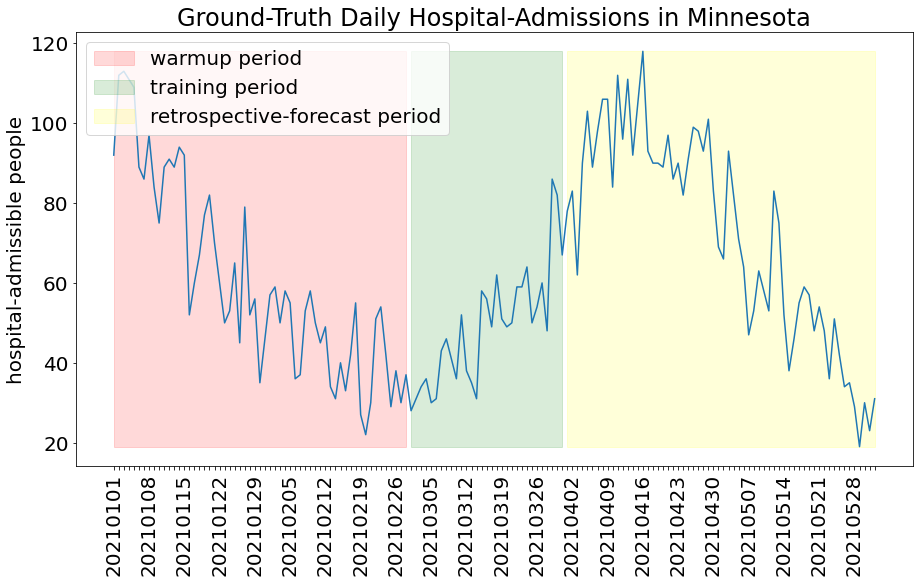

In [2]:

# state_name = 'California'
# state_abbrev = 'CA' 

state_name = 'Minnesota'
state_abbrev = 'MN' 

results_folder = 'results/'
data_folder = 'data/'

# training_start_date = '20210101'
# training_end_date = '20210401' 

training_start_date = '20210301'
training_end_date = '20210401' 


# ground truth data from a lookback_date to '20210601' to guide model's predictions toward a good fit
lookback_date = '20210101'
hd_truthful = HospitalData('HHS_data_selective.csv', state_abbrev,lookback_date,'20210601')
truthful_Admission_counts = hd_truthful.get_Admission_counts()
plt.figure(figsize=(15,8))    
plt.plot(truthful_Admission_counts);

date_xlabels = [d if i%7 == 0 else '' for i,d in enumerate(hd_truthful.filtered_data['date']) ]
plt.xticks(range(len(date_xlabels)), labels=date_xlabels, Rotation=90);
plt.title('Ground-Truth Daily Hospital-Admissions in ' + state_name )
plt.ylabel('hospital-admissible people')
training_end_date_idx = list(hd_truthful.filtered_data['date']).index(training_end_date)
training_start_date_idx = list(hd_truthful.filtered_data['date']).index(training_start_date)

h1 = plt.fill_between(range(training_start_date_idx), min(truthful_Admission_counts), max(truthful_Admission_counts),alpha=0.15, color='red')
h2 = plt.fill_between(range(training_start_date_idx,training_end_date_idx), min(truthful_Admission_counts), max(truthful_Admission_counts),alpha=0.15, color='green')
h3 = plt.fill_between(range(training_end_date_idx,len(truthful_Admission_counts)), min(truthful_Admission_counts), max(truthful_Admission_counts),alpha=0.15, color='yellow')
plt.legend(handles=[h1,h2, h3], labels=["warmup period", "training period", "retrospective-forecast period"])
plt.show()


## Defining the model with the warmup dataset (red-shaded on plot) from covidestim.org

covidestim.org data from lookback_date to the training_start_date will be used to warm up the model 

In other words at timepoint t=training_start_date, values for the compartmental stage Infected ,Symptomatic ,Ailing ,Hospital-admissible are calculated from the following covidestim.org data in the red-shaded time period

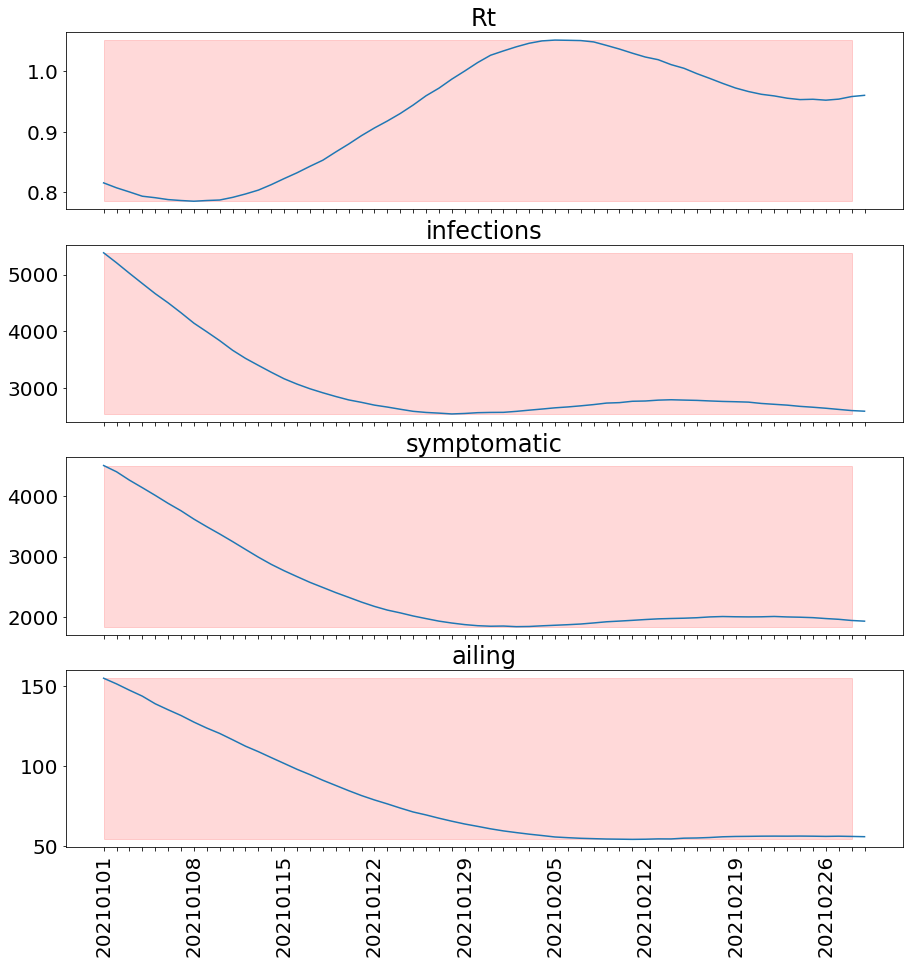

In [3]:

# getting data from covidestim.org
pd_warmup_data = PopulationData(data_folder+"covidestim.csv", state_name, 
                                start_date=lookback_date, end_date=training_start_date);


# print(pop_model.warmup_data.filtered_data)
fig, [warmup_ax1, warmup_ax2, warmup_ax3, warmup_ax4] = plt.subplots(nrows=4, ncols=1,figsize=(15,15))    

x_dates = pd_warmup_data.filtered_data['date']
x_dates = [x if e%7==0 else '' for e,x in enumerate(x_dates)]
for e,(i,k) in enumerate(zip([1,2,3,4], ['Rt','infections','symptomatic','ailing'])):
    eval('warmup_ax' +str(i) +'.plot(pd_warmup_data.filtered_data[k])')
    eval('warmup_ax' +str(i) +'.set_title(k)')
    eval('warmup_ax' +str(i)+'.axes.xaxis.set_ticklabels([])')
    eval('warmup_ax' +str(i)+'.set_xticks(range(len(x_dates)))')    
    eval('warmup_ax' +str(i)+'.fill_between(range(training_start_date_idx), min(pd_warmup_data.filtered_data[k]), max(pd_warmup_data.filtered_data[k]),alpha=0.15, color="red")')    
    
plt.xticks(range(len(x_dates)),x_dates, rotation=90);


# Initialzing a population model
pop_model = PopulationModel(warmup_data_obj=pd_warmup_data)


In [4]:
# Other US states that CovidEstim is tracking
pd_warmup_data.data['state'].unique()

dtype: str
Rows: 34
['Missouri', 'Oregon', 'New Hampshire', 'Georgia', 'Mississippi', 'Kansas', 'South Dakota', 'Delaware', 'Hawaii', 'Wisconsin', 'Tennessee', 'Utah', 'New Mexico', 'Puerto Rico', 'Louisiana', 'Vermont', 'Arkansas', 'Nebraska', 'Oklahoma', 'West Virginia', 'Maine', 'Alaska', 'Nevada', 'North Carolina', 'California', 'Idaho', 'Washington', 'Minnesota', 'Iowa', 'Kentucky', 'Montana', 'Wyoming', 'Alabama', 'North Dakota']

# Step 1.
## Fit the model to a given training dataset from HHS hospital admissions

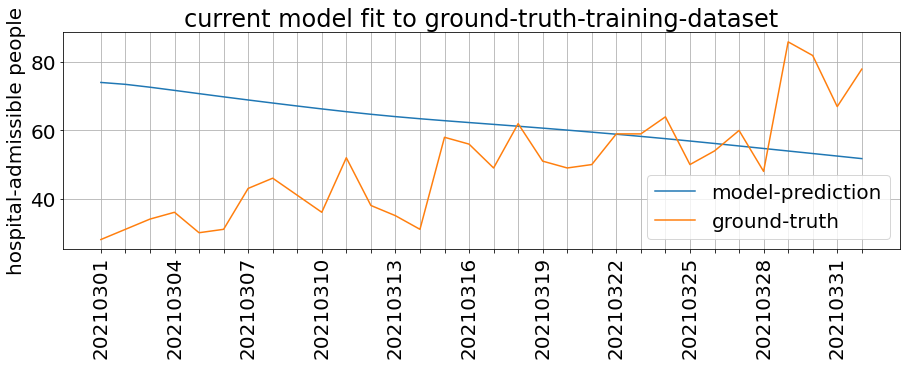

----------------------Iter  0 ----------------------
182.77682525365722 loss at iteration 
-9.08713546267322 symptomatic gradient at iteration 


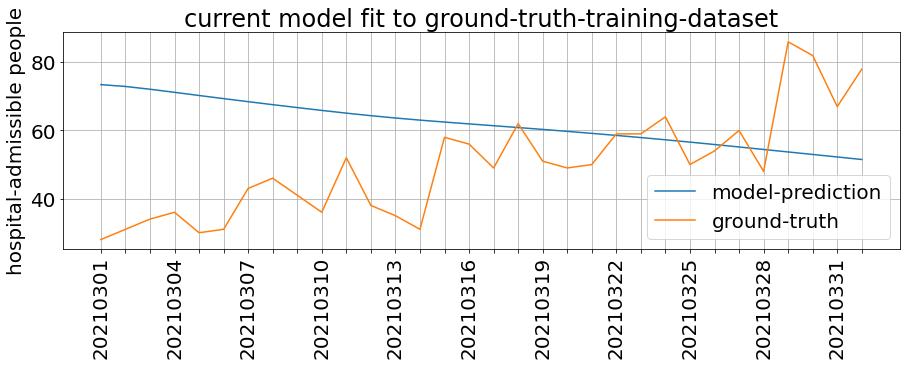

----------------------Iter  5 ----------------------
182.25380866822164 loss at iteration 
-12.521098403948532 symptomatic gradient at iteration 


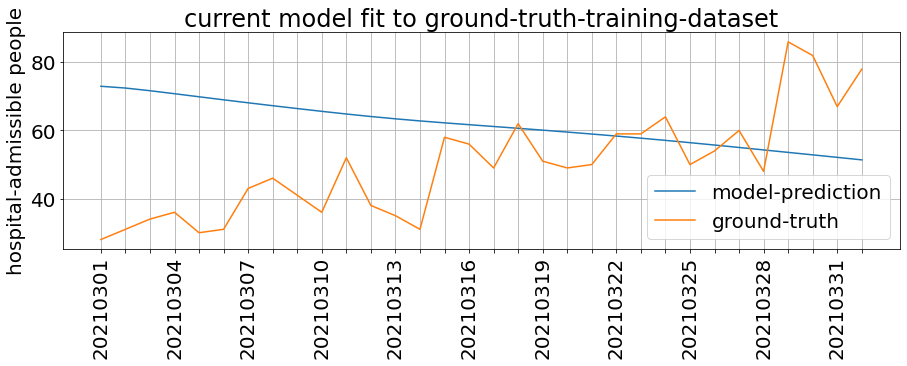

----------------------Iter  10 ----------------------
181.79238166990766 loss at iteration 
-14.476414954905488 symptomatic gradient at iteration 


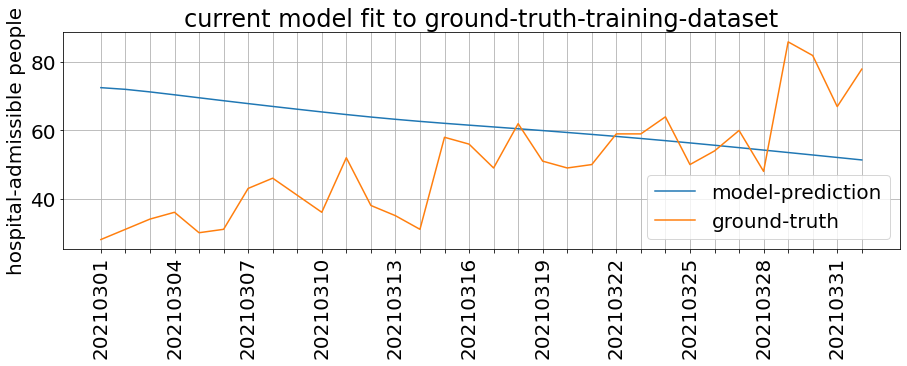

----------------------Iter  15 ----------------------
181.33370044881573 loss at iteration 
-15.612106724594634 symptomatic gradient at iteration 


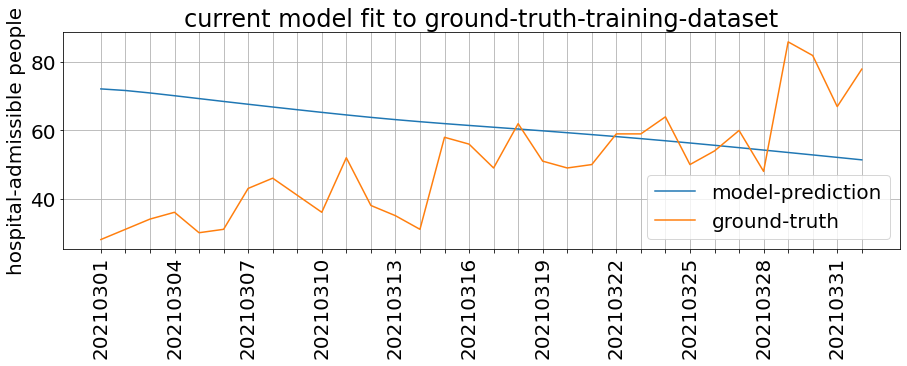

----------------------Iter  20 ----------------------
180.85741664253823 loss at iteration 
-16.2929873454582 symptomatic gradient at iteration 


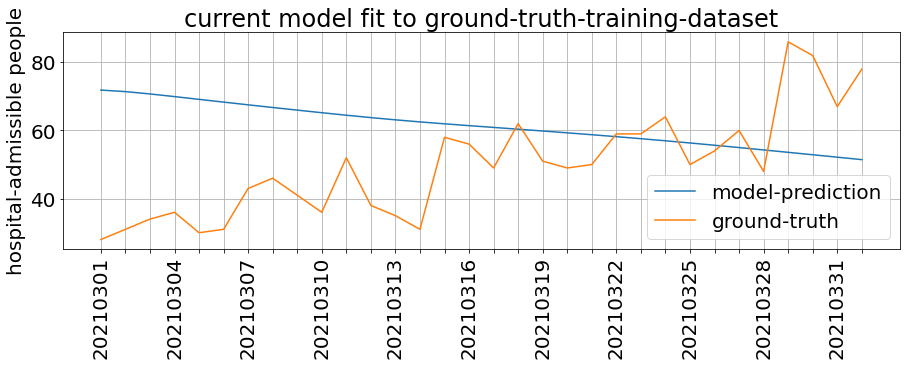

----------------------Iter  25 ----------------------
180.3548186050565 loss at iteration 
-16.72207131671865 symptomatic gradient at iteration 


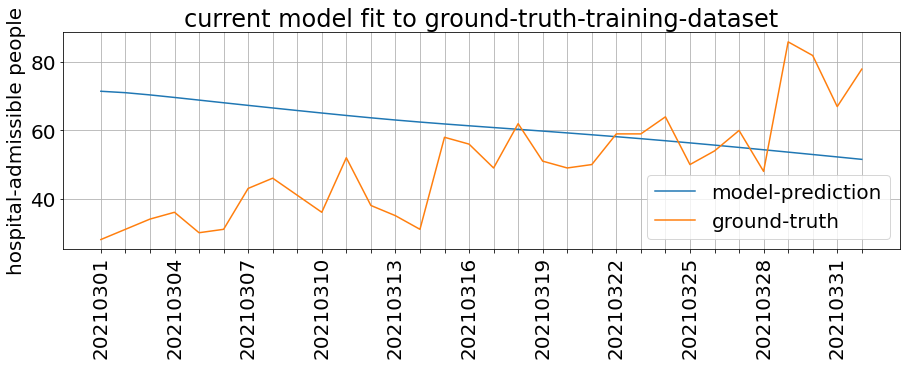

----------------------Iter  30 ----------------------
179.8203601514772 loss at iteration 
-17.012517368797017 symptomatic gradient at iteration 


In [5]:
training_data_obj = HospitalData('HHS_data_selective.csv', state_abbrev, start_date=training_start_date,end_date=training_end_date)
pop_model.warmup_data.end_date = training_start_date
pop_model.fit(training_data_obj, 
              n_iters=32, step_size_txn=5e-5, step_size_soj=9e-4, n_steps_between_print=5, lambda_reg=1e-3, plots=True)

## See how gradient descent did in terms of reducing the loss function over each iteration

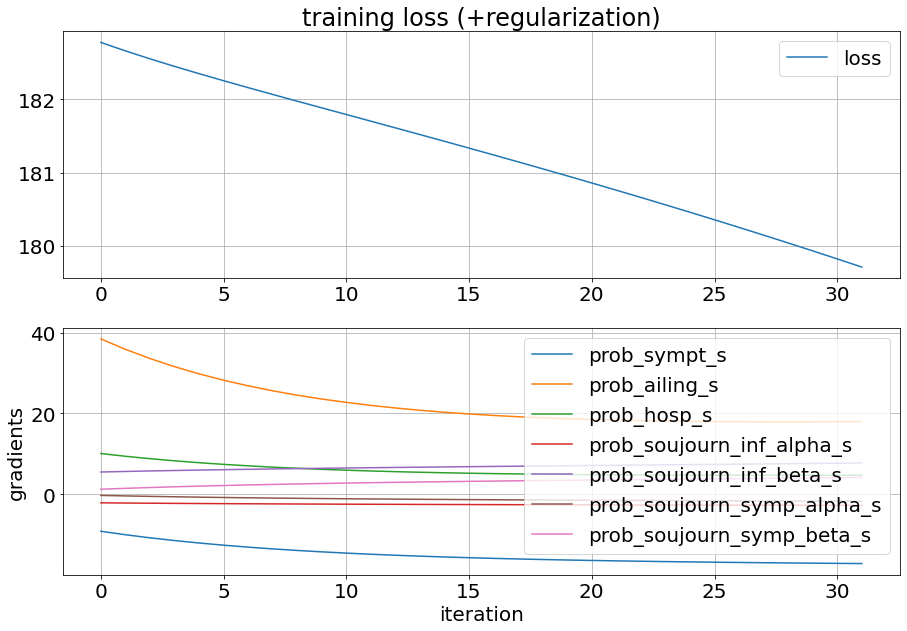

In [6]:
fig, [train_ax1, train_ax2] = plt.subplots(nrows=2, ncols=1,figsize=(15,10))    

train_ax1.plot(pop_model.loss_per_iter, label='loss')
train_ax1.set_title('training loss (+regularization)')
train_ax1.legend()
train_ax1.grid()

for k,v in pop_model.gradients_per_iter.items():
    if k in ['prob_sympt_s',
                'prob_ailing_s',
                'prob_hosp_s',
                'prob_soujourn_inf_alpha_s',
                'prob_soujourn_inf_beta_s',
                'prob_soujourn_symp_alpha_s',
                'prob_soujourn_symp_beta_s']:
        train_ax2.plot(v,label=k)

train_ax2.legend()
train_ax2.grid()
train_ax2.set_ylabel('gradients')
train_ax2.set_xlabel('iteration')
plt.show()


### Does model need further training? 
 - Does training loss converge?
 - Do all gradients converge towards 0 on the final iteration?

# Step 2.
## Use the optimized/learned pop_model.params to forecast beyond the training dates

- setting save_admissions = True will generate forecasted_admissions.csv
- change the pop_model.warmup_data.end_date = training_end_date such that model will forecast from training_end_date and beyond


{'T_serial': 5.807005205326036, 'Rt_shift': 0.2, 'days_of_imposed_restrictions': [], 'days_of_relaxed_restrictions': [], 'prob_sympt_s': 0.6419451133417431, 'prob_ailing_s': -2.9794616293293448, 'prob_hosp_s': 1.0893692716283554, 'prob_soujourn_inf_alpha_s': 3.4448002638137214, 'prob_soujourn_inf_beta_s': -0.3743817027917798, 'prob_soujourn_symp_alpha_s': 1.4318238589503411, 'prob_soujourn_symp_beta_s': -1.4980390673188695}


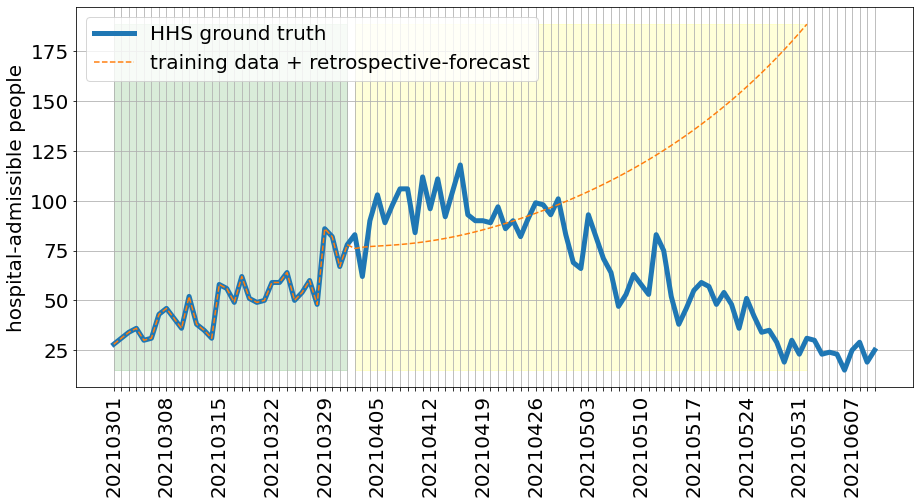

In [7]:
pop_model.training_mode=False
pop_model.warmup_data.end_date = training_end_date
pop_model.forecast_duration=60

print(pop_model.params)
plt.figure(figsize = (15,7))


training_hospitalizations = list(training_data_obj.get_Admission_counts())
forecasted_hospitalizations = list(pop_model.get_forecasted_data(save_admissions=False)['hospitalized']) 
training_forecasted_hospitalizations = training_hospitalizations + forecasted_hospitalizations
hd_observed = HospitalData('HHS_data_selective.csv', state_abbrev,training_start_date,'20210610')
hd_observed_hospitalizations = list(hd_observed.get_Admission_counts())                                   

plt.plot(hd_observed_hospitalizations, label= 'HHS ground truth', linewidth=5)
plt.plot(training_forecasted_hospitalizations,label='training data + retrospective-forecast', linestyle='--' )


min_val  = min(training_forecasted_hospitalizations+hd_observed_hospitalizations)
max_val  = max(training_forecasted_hospitalizations+hd_observed_hospitalizations)
plt.fill_between(range(len(training_hospitalizations)), min_val, max_val,
                 alpha=0.15, color='green')
plt.fill_between(range(len(training_hospitalizations),len(training_forecasted_hospitalizations)), min_val, max_val,
                alpha=0.15, color='yellow')

                                                                                                                                      
x_dates=list(hd_observed.filtered_data['date'])
x_dates = [x if e%7==0 else '' for e,x in enumerate(x_dates)]                                                                                                                                      
plt.xticks(range(len(x_dates)),x_dates, rotation=90 );
plt.ylabel('hospital-admissible people')
plt.legend()
plt.grid()
plt.show()

### How does the model perform in terms of retrospective-forecasting? 
- In this retrospective forecasting, note that model only sees data within green shaded period and forecasts, without ever having seen any information in the yellow shaded period. As a result of the limited data seen by the model, the user should not expect a perfect fit to the HHS ground truth.   

### Some trouble shooting tips
- maybe model needs more training?
- maybe prior distributions need to be redefined for given state?
- unexpected government policies enforced for this state?
- people all of a sudden gather in crowded areas for family events? (i.e Christmas, New Years)

# Forecasting beyond today 
- change the pop_model.warmup_data.end_date = TODAY_DATE such that model will forecast from TODAY_DATE and beyond, 
- to account for potential data source api deprecations, we set TODAY_DATE as '20210610' because we know that all of HHS and Covidestim.org data exists up to this date



 ***forecasted hospital-admissible numbers saved to  results/forecasted_admissions.csv


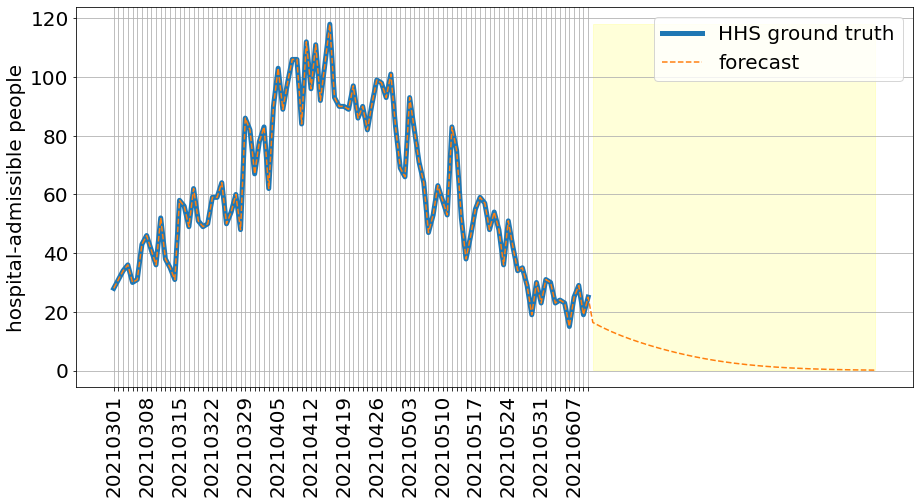

In [8]:
pop_model.training_mode=False
pop_model.warmup_data.end_date = '20210610'
pop_model.forecast_duration=60

# print(pop_model.params)
plt.figure(figsize = (15,7))


# training_hospitalizations = list(training_data_obj.get_Admission_counts())
forecasted_hospitalizations = list(pop_model.get_forecasted_data(save_admissions=True)['hospitalized']) 
# training_forecasted_hospitalizations = training_hospitalizations + forecasted_hospitalizations
hd_observed = HospitalData('HHS_data_selective.csv', state_abbrev,training_start_date,pop_model.warmup_data.end_date)
hd_observed_hospitalizations = list(hd_observed.get_Admission_counts())                                   

plt.plot(hd_observed_hospitalizations, label= 'HHS ground truth', linewidth=5)
plt.plot(hd_observed_hospitalizations + forecasted_hospitalizations,label='forecast', linestyle='--' )


min_val  = min(hd_observed_hospitalizations + forecasted_hospitalizations)
max_val  = max(hd_observed_hospitalizations + forecasted_hospitalizations)

plt.fill_between(range(len(hd_observed_hospitalizations),len(hd_observed_hospitalizations + forecasted_hospitalizations)), min_val, max_val,
                alpha=0.15, color='yellow')

                                                                                                                                      
x_dates=list(hd_observed.filtered_data['date'])
x_dates = [x if e%7==0 else '' for e,x in enumerate(x_dates)]                                                                                                                                      
plt.xticks(range(len(x_dates)),x_dates, rotation=90 );
plt.ylabel('hospital-admissible people')
plt.legend()
plt.grid()
plt.show()

# Step 3. 
## Inspect the learned parameters with respect to their given prior distributions

- In this notebook, (if the init_param is not passed as an argument to the pop_model.fit function) the model is initialized with parameters values at the mode of each prior distribution 

- over iterations of gradient descent, the learned parameters may drift away from the initial values, thus resulting in new point-estimate values (dashed blue line in plots below)

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

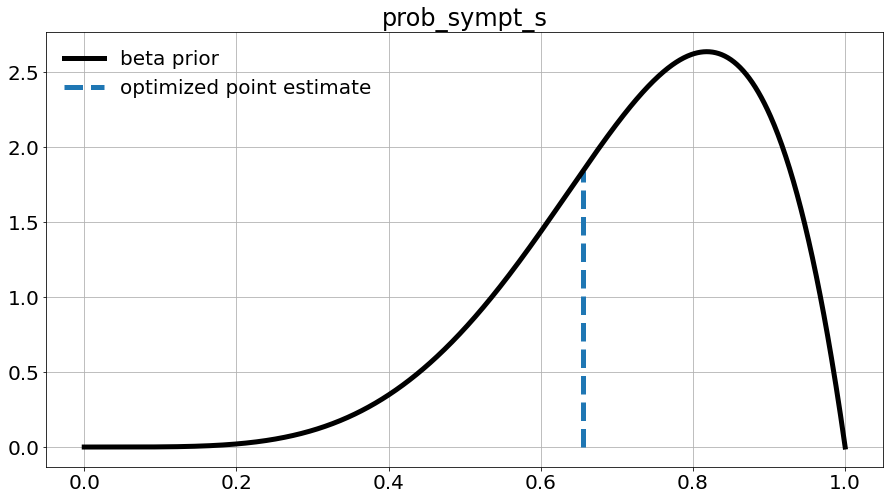

------


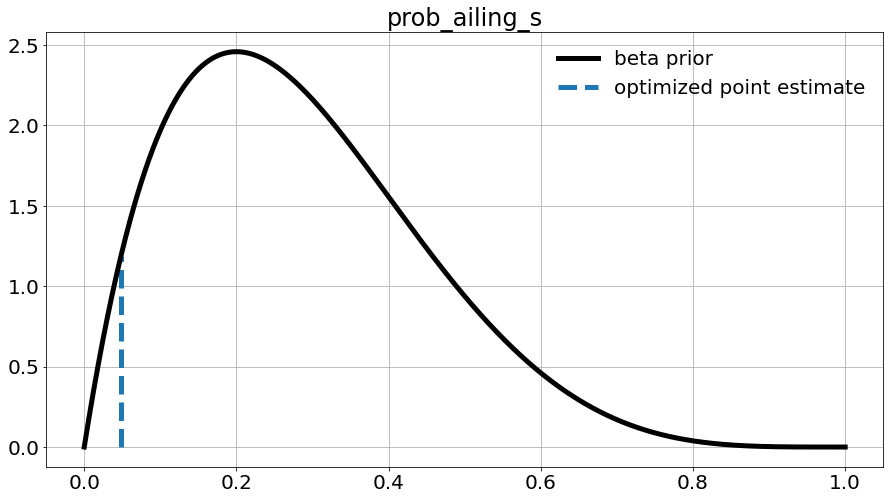

------


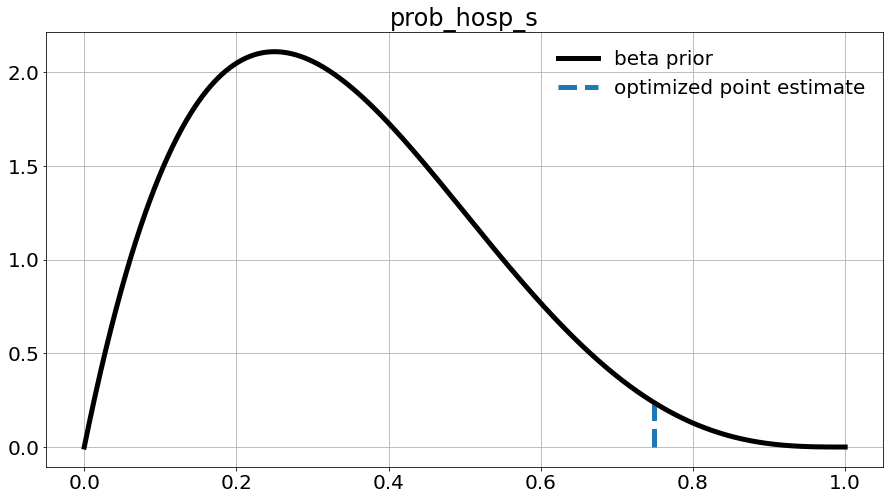

------


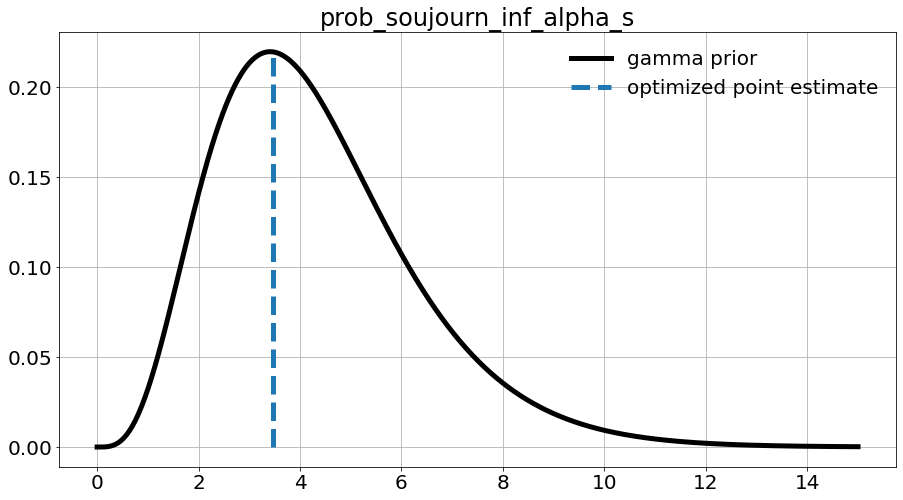

------


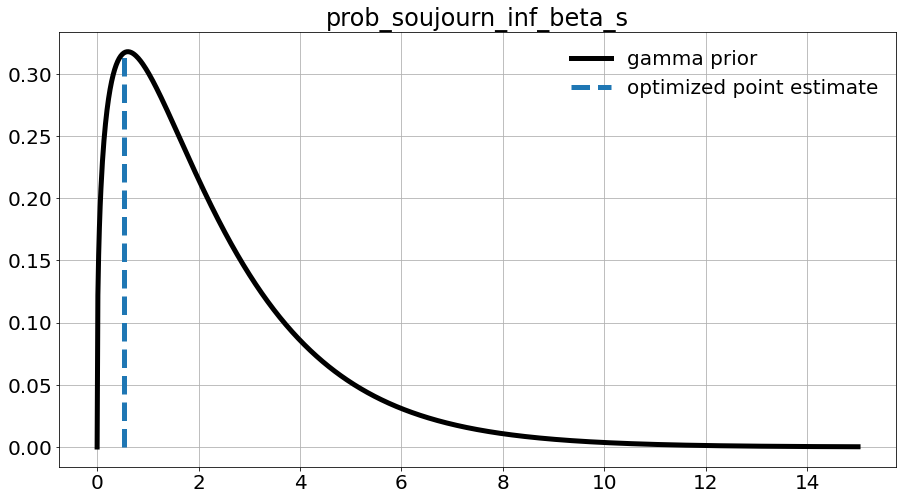

------


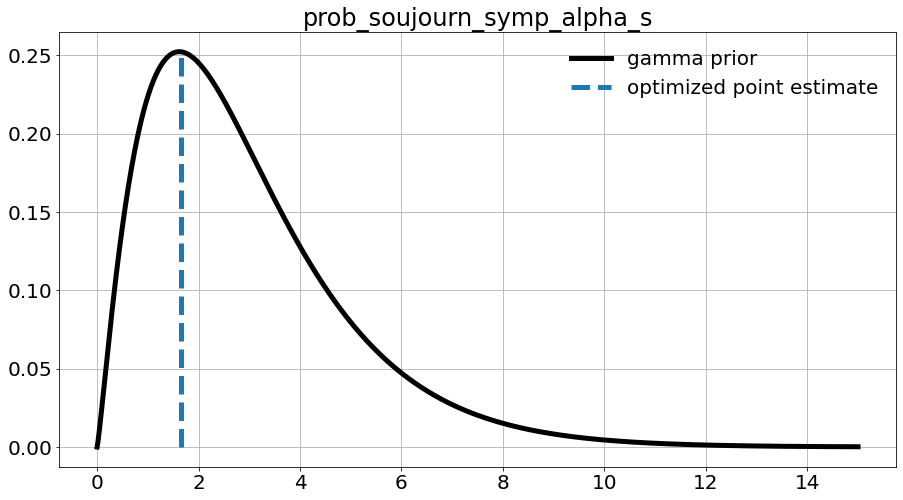

------


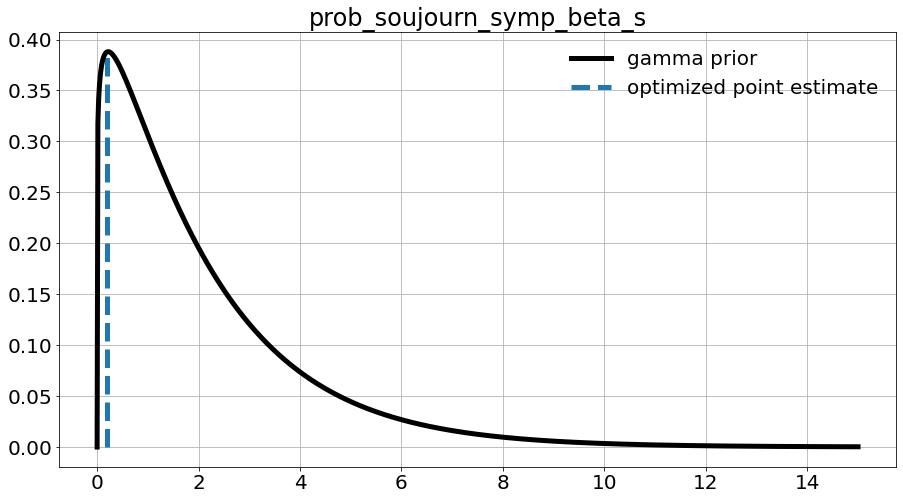

------


In [9]:
from scipy.stats import beta
from scipy.stats import gamma
from autograd.scipy.special import expit as sigmoid
softplus = lambda x: np.log(1+np.exp(x))

        
for k,v in pop_model.priors.items():
    plt.figure(figsize=(15,8));
    if k in ['T_serial', 'Rt_shift', 'days_of_imposed_restrictions', 'days_of_relaxed_restrictions']:
        continue
    a = v[0]
    b = v[1]
    mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
    if k in ['prob_sympt_s','prob_ailing_s','prob_hosp_s']:
        x = np.linspace(0,1,1000)
        pdf_vals = beta.pdf(x, a, b)
        imax = np.argmax(pdf_vals)
        plt.plot(x, pdf_vals,
               'k-', lw=5, label='beta prior');
        param_val =sigmoid(pop_model.params[k] )
        plt.vlines(param_val,np.min(pdf_vals),beta.pdf(param_val, a, b), label='optimized point estimate', linestyle='--', linewidth=5);
        plt.legend(loc='best', frameon=False);
        plt.title(k);
        plt.grid();

        plt.show();


    elif k in ['prob_soujourn_inf_alpha_s','prob_soujourn_inf_beta_s','prob_soujourn_symp_alpha_s','prob_soujourn_symp_beta_s']:
        param_val = softplus(pop_model.params[k])
        x = np.linspace(0,15, 1000)
        rv = gamma(a,scale=1/b)
        pdf_vals = rv.pdf(x)
        imax = np.argmax(pdf_vals)
        plt.plot(x, pdf_vals, 'k-', lw=5, label='gamma prior');
        plt.vlines(param_val, ymin=0,ymax=rv.pdf(param_val),label='optimized point estimate',linestyle='--', linewidth=5);
        plt.legend(loc='best', frameon=False);
        plt.grid();
        plt.title(k);

        plt.show();


    print('------')

    

# Show how point-estimated sojourn parameters (alphas, betas) creates  Maximum-a-Priori (MAP) sojourn Probability Mass Functions (PMFs)

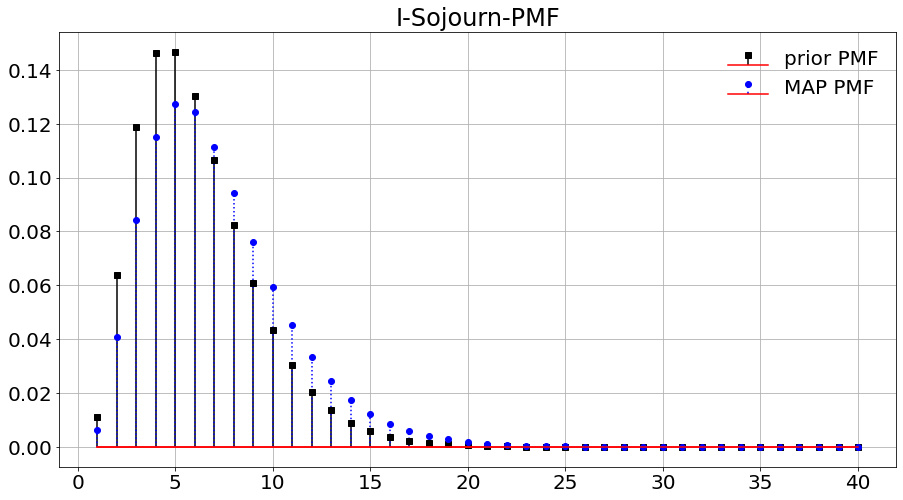

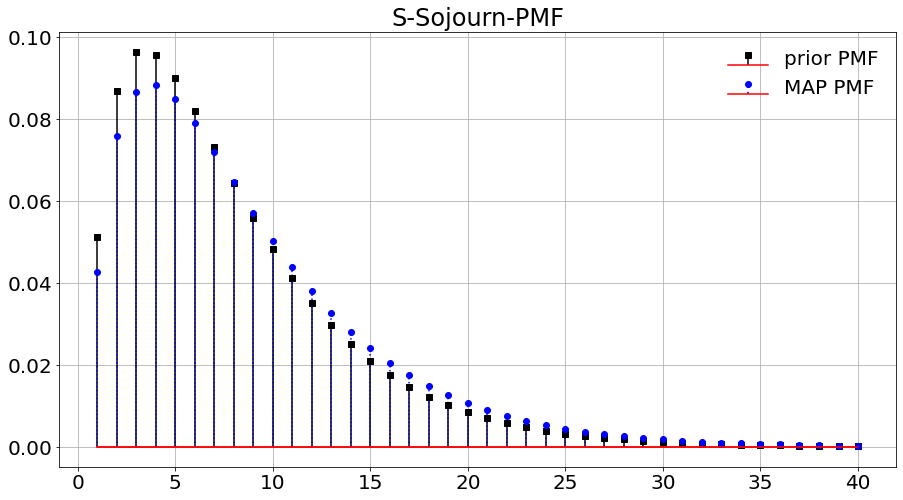

In [10]:
from matplotlib.pyplot import stem
from autograd_gamma import gammainc
def gamma_at_x(params,x):
    if x==0:
        return 0.0 
    if x==1:
        return cdf_at_x(params,x)
    elif x>1:
        return cdf_at_x(params,x) - cdf_at_x(params,x-1)

def cdf_at_x(params,x):
    return (gammainc(params['alpha'],params['beta']*x))

########## INFECTED SOJOURN
plt.figure(figsize=(15,8));
alpha_mode_from_prior = 3.41 # from looking at mode value at prior pdf plotted above
beta_mode_from_prior = .605
x = np.linspace(1,40, 40)
stem(x, [gamma_at_x({'alpha':alpha_mode_from_prior,
                     'beta':beta_mode_from_prior},val) for val in x], linefmt='k-', markerfmt='ks', basefmt='r-', label='prior PMF')
stem(x, [gamma_at_x({'alpha':softplus(pop_model.params['prob_soujourn_inf_alpha_s']),
                    'beta':softplus(pop_model.params['prob_soujourn_inf_beta_s'])},val) for val in x], linefmt='b:', markerfmt='bo', basefmt='r-', label='MAP PMF')
plt.title('I-Sojourn-PMF')
plt.legend(loc='best', frameon=False)
plt.grid()
plt.show()
        
        
########## SYMPTOMATIC SOJOURN
plt.figure(figsize=(15,8));
alpha_mode_from_prior = 1.62 # from looking at mode value at prior pdf plotted above
beta_mode_from_prior = .218
stem(x, [gamma_at_x({'alpha':alpha_mode_from_prior,
                     'beta':beta_mode_from_prior},val) for val in x], linefmt='k-', markerfmt='ks', basefmt='r-', label='prior PMF')
stem(x, [gamma_at_x({'alpha':softplus(pop_model.params['prob_soujourn_symp_alpha_s']),
                    'beta':softplus(pop_model.params['prob_soujourn_symp_beta_s'])},val) for val in x], linefmt='b:', markerfmt='bo', basefmt='r-', label='MAP PMF')
plt.title('S-Sojourn-PMF')
plt.legend(loc='best', frameon=False)
plt.grid()
plt.show()

# At the time of forecasting, Rt values are approximated with linear interpolation


Text(0.5, 1.0, 'Compare the linear interpolated Rt to CovidEstim Rt ')

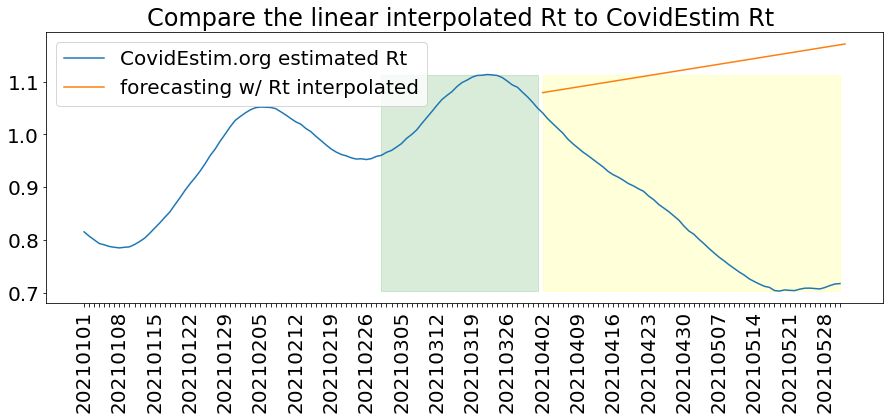

In [11]:


pop_model.warmup_data.end_date = training_end_date
pd_estim_data = PopulationData(data_folder+"covidestim.csv", state_name,lookback_date, end_date=str(pop_model.get_dates_to_forecast()[-1]));
days_before_Rt_interpolation = (len(pd_estim_data.filtered_data['Rt']) - pop_model.forecast_duration)

plt.figure(figsize=(15,5))
plt.plot(pd_estim_data.filtered_data['Rt'], label='CovidEstim.org estimated Rt')
plt.plot(([np.nan]*days_before_Rt_interpolation) +  list(pop_model.get_forecasted_data()['Rt']), label='forecasting w/ Rt interpolated');

x_dates = pd_estim_data.filtered_data['date']
x_dates = [x if e%7==0 else '' for e,x in enumerate(x_dates)]   
plt.xticks(range(len(x_dates)),x_dates, rotation=90)

plt.fill_between(range((days_before_Rt_interpolation),len(x_dates)), 
                 min(pd_estim_data.filtered_data['Rt']), max(pd_estim_data.filtered_data['Rt']),
                alpha=0.15, color='yellow')

plt.fill_between(range((days_before_Rt_interpolation-(pop_model.training_data.filtered_data.num_rows())),(days_before_Rt_interpolation)), 
                 min(pd_estim_data.filtered_data['Rt']), max(pd_estim_data.filtered_data['Rt']),
                alpha=0.15, color='green')
plt.legend()
plt.title('Compare the linear interpolated Rt to CovidEstim Rt ')
# plt.grid()
